# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

## 2. Read data

### select one dataset:

In [2]:
dataset = 2

1D spectra

2D images:

In [3]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [4]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [5]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [6]:
data_dimensionality = len(data.shape)

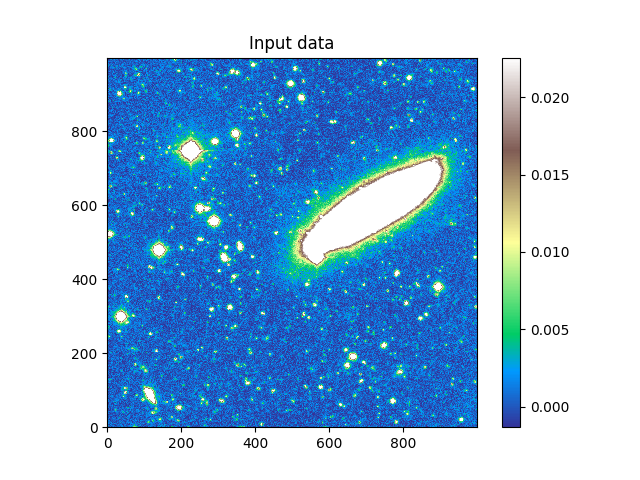

In [7]:
if data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)

In [8]:
if data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)

    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data**2, axis=0)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_title('Input data (rms value along specral axis)')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data**2, axis=2)).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data**2, axis=1)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    
    cb = fig.colorbar(im, ax=ax[1, 1])
    ax[1, 1].set_visible(False)

## 3. Find mode

### number density and cumulative fraction:

Note: I removed the possibility of statistical weights.

In [9]:
sorted_data = np.sort(data.flatten())
sorted_data = np.hstack([sorted_data[0], (sorted_data[1:]+sorted_data[:-1])/2, sorted_data[-1]])
number_fraction = np.arange(data.size+1)/data.size

And I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [10]:
d50 = sorted_data[data.size//2]
print(f'Data median: {d50:.3g}')
bg_std = np.std(sorted_data[:data.size//2])
print(f'First guess of background standard deviation: {bg_std:.3g}')
data_std = np.std(data)

d_left = sorted_data[1]
d_right = 2*d50 - d_left
n_steps = int(100*(d_right-d_left)/bg_std)
data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')

Data median: 0.000786
First guess of background standard deviation: 0.000756
Data subsampled to 1520 linear steps between -0.00496 and 0.00654


Smooth density field:

In [11]:
h_smooth = bg_std
m_left = np.interp(data_sample-h_smooth/2, sorted_data, number_fraction)
m_right = np.interp(data_sample+h_smooth/2, sorted_data, number_fraction)
data_sample_rho = (m_right-m_left) / h_smooth

### density mode:

Naive method:

In [12]:
data_mode = data_sample[np.argmax(data_sample_rho)]
print(f'Naive mode:{data_mode:.3g}')

Naive mode:0.000442


More stable:

In [13]:
weight = data_sample_rho**10
data_mode = np.sum(data_sample*weight) / np.sum(weight)
print(f'More stable:{data_mode:.3g}')

More stable:0.000457


In [14]:
bg_std = np.std(data[data < data_mode])
print(f'background std={bg_std:.3g}')

background std=0.000694


## 4. Signal / background classification

### compute probability:

Asumming that the background intensity is symmetric around $I_0$, which is well traced by the mode,
$$ p_{bg}(I > I_0) = \frac{p(2I_0-I)}{p(I)} ~~;~~ p_{src} = 1 - p_{bg}$$

In [15]:
rho_sym = np.interp(2*data_mode-data_sample, data_sample, data_sample_rho, left=0)
probability_bg = np.clip(rho_sym/data_sample_rho, 0, 1)
src_probability_map = 1 - np.interp(data, data_sample, probability_bg)

### estimate threshold:

a) The number of background pixels is the same above and below mode:

In [16]:
N_mode = np.count_nonzero(data < data_mode)
N_src = np.sum(src_probability_map)
N_background = data.size-N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

number_threshold = sorted_data[int(N_background)]
print(f'Number-based threshold={number_threshold:.3g}, ({(number_threshold-data_mode)/bg_std:.3g} sigmas)')

409730 (41.0%) pixels below mode
819312.8477904988 (81.9%) background pixels; N_background/N_mode=1.9996408556622622
180687.15220950125 (18.1%) source pixels; N_pixels-2N_mode=180540
Number-based threshold=0.0027, (3.24 sigmas)


b) The background flux is the same:

In [17]:
index_mode = np.searchsorted(sorted_data, data_mode)
total_flux_below_mode = np.sum(data_mode-sorted_data[:index_mode])
flux_above_mode = np.cumsum(sorted_data[index_mode:]-data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, sorted_data[index_mode:])
print(f'Total flux: {total_flux_below_mode:.3g} below mode, {flux_above_mode[-1]:.3g} above')
print(f'Flux-based threshold={flux_threshold:.3g} ({(flux_threshold-data_mode)/bg_std:.3g} sigmas)')

Total flux: 379 below mode, 1.32e+04 above
Flux-based threshold=0.00283 (3.42 sigmas)


c) Below the mode, $p_{src}$ and $p_{bg}$ should be zero and one, respectively. The maximum difference found sets the (un)reliable regime:

In [18]:
reliable_bg_probability = np.min(probability_bg[data_sample < data_mode])
reliable_src_probability = 1 - reliable_bg_probability
probability_threshold = np.min(data_sample[probability_bg < reliable_bg_probability])
print(f'Reliable probabilities: p_src > {reliable_src_probability:.3g}; p_bg < {reliable_bg_probability:.3g}')
print(f'Probability-based threshold={probability_threshold:.3g} ({(probability_threshold-data_mode)/bg_std:.3g} sigmas)')

Reliable probabilities: p_src > 0.00698; p_bg < 0.993
Probability-based threshold=0.00125 (1.14 sigmas)


Now, take the minimum of three:

In [19]:
threshold_guess = min([number_threshold, flux_threshold, probability_threshold])
delta_th = (threshold_guess - data_mode) / bg_std

In [48]:
colour_scale = colors.SymLogNorm(vmin=-3*delta_th, linthresh=3*delta_th, vmax=(np.nanmax(data)-data_mode)/bg_std)

### summary plot:

Text(0.5, 0, 'data value')

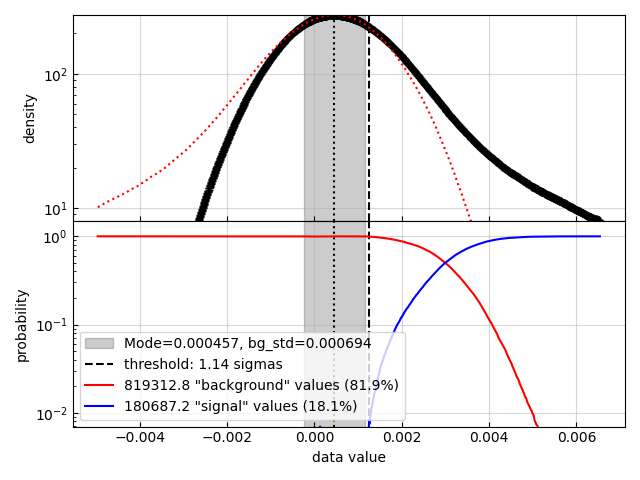

In [20]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                  sharex='col', sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
    axis.set_aspect('auto')
    axis.axvline(data_mode, c='k', ls=':')
    axis.fill_between(data_sample, 0, 1, where=np.abs(data_sample-data_mode) <= bg_std,
                      color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                      label=f'Mode={data_mode:.3g}, bg_std={bg_std:.3g}')
    axis.axvline(threshold_guess, c='k', ls='--', label=f'threshold: {delta_th:.3g} sigmas')
fig.set_tight_layout(True)

ax[0, 0].set_ylabel('density')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(np.min(data_sample_rho[data_sample > data_mode]), np.max(data_sample_rho))
ax[0, 0].plot(data_sample, data_sample_rho, 'k+', label='total')
ax[0, 0].plot(data_sample, rho_sym, 'r:', label='background')

ax[1, 0].set_ylabel('probability')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(reliable_src_probability, 1.5)
ax[1, 0].plot(data_sample, probability_bg, 'r-',
              label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
ax[1, 0].plot(data_sample, 1-probability_bg, 'b-',
              label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
ax[1, 0].legend()

#ax[-1, 0].set_xlim(x_f[0], data_mode+5*delta_th)
ax[-1, 0].set_xlabel('data value')


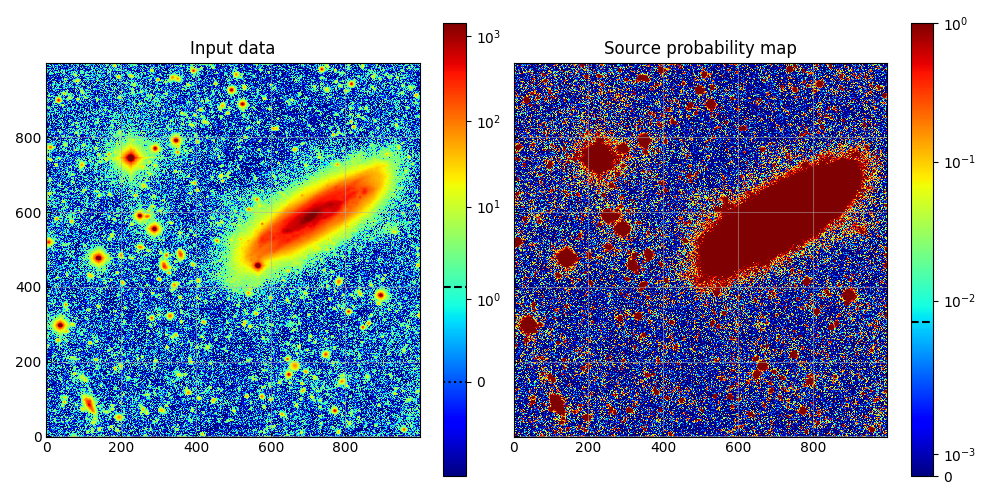

In [21]:
if data_dimensionality == 2:
    plt.close('bg_map')
    fig = plt.figure('bg_map', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        (data-data_mode)/bg_std,
        interpolation='nearest', origin='lower', cmap='jet',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=delta_th, vmax=(np.nanpercentile(data, 99.9)-data_mode)/bg_std),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(delta_th, c='k', ls='--')
    cb.ax.axhline(0, c='k', ls=':')

    ax[0, 1].set_title('Source probability map')
    im = ax[0, 1].imshow(
        src_probability_map,
        interpolation='nearest', origin='lower', cmap='jet',
        norm = colors.SymLogNorm(vmin=0, linthresh=reliable_src_probability, vmax=1),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(reliable_src_probability, c='k', ls='--')


## 5. Hierarchical Overdensity Tree (HOT)

### routine definition:

$$ S = \sum p_i (I_i - I_0) $$
$$ \sigma^2 = 2\sigma_0^2 \sum p_i $$

$$ n = \sum p_i $$
$$ \Delta S_n = p_n I_n + (n-1) I_{n-1} - n I_n = (p_n - 1) I_n + (n-1) (I_{n-1}-I_n) $$
$$ \Delta S_n > 0 ~~ \iff ~~ I_n < \frac{n-1}{1-p_n} I_{n-1} ~;~ 1-p_n < (n-1) \frac{I_{n-1}}{I_n} $$

$$ \Delta \sigma^2_i = p_i 2\sigma_0^2 $$

$$ \Delta \ln(S/N)^2 \sim \frac{(S+\Delta S)^2}{\sigma^2 + \Delta \sigma^2 } \frac{\sigma^2}{S^2} $$
$$ \propto \frac{S^2+p^2I^2+2pI}{1 + p } $$

$$
(S/N)^2_{a+b} = \frac{ (S_a + S_b)^2 }{ \sigma^2_a + \sigma^2_b }
= \frac{ \sigma^2_a\frac{S^2_a}{\sigma^2_a} + \sigma^2_b\frac{S^2_b}{\sigma^2_b}
        + 2 \sigma_a\sigma_b\frac{S_a}{\sigma_a}\frac{S_b}{\sigma_b} }{ \sigma^2_a + \sigma^2_b }
$$ 

In [22]:
HOT_threshold = delta_th

In [23]:
@njit
def hot(data, src_probability, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    flat_data = data.ravel()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    #probability = np.zeros_like(src_probability)
    max_value = np.full(data.size, threshold, dtype=data.dtype)
    min_value = np.full(data.size, threshold, dtype=data.dtype)
    sum_value = np.zeros(data.size, dtype=data.dtype)
    max_signal_to_noise = np.zeros(data.size, dtype=data.dtype)
    signal_to_noise_threshold = np.zeros(data.size, dtype=data.dtype)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        src_probability[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < flat_data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent
                min_value[p] = pixel_value
                #if p != selected_parent:
                    #sum_value[selected_parent] += sum_value[p]
                    #area[selected_parent] += area[p]

        label[pixel] = selected_parent
        area[selected_parent] += 1
        #probability[selected_parent] += src_probability[pixel]
        min_value[selected_parent] = pixel_value
        sum_value[selected_parent] += pixel_value
        n = area[selected_parent]
        signal_to_noise = (sum_value[selected_parent] - n*pixel_value) / np.sqrt(n)
        if signal_to_noise > max_signal_to_noise[selected_parent]:
            max_signal_to_noise[selected_parent] = signal_to_noise
            signal_to_noise_threshold[selected_parent] = pixel_value
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               min_value[:n_labels+1],
               #probability[:n_labels+1],
               max_signal_to_noise[:n_labels+1],
               signal_to_noise_threshold[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [24]:
src_probability_inv = 1 - np.interp(2*data_mode-data, data_sample, probability_bg)
label_inv, catalog_inv = hot((data_mode-data)/bg_std, src_probability_inv.flatten(), HOT_threshold)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
min_value_inv = catalog_inv[3]
max_signal_to_noise_inv = catalog_inv[4]
signal_to_noise_threshold_inv = catalog_inv[5]


103903 overdensities found: 202841 "pixels" (20%), 76704 independent regions


Compute the upper hull of the inverted catalogue:

In [25]:
def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]


#good_hull = (area_inv > 0)
#log_area_inv = np.log(area_inv[good_hull])
#contrast = max_value_inv[good_hull]-min_value_inv[good_hull]
log_area_inv = np.log(area_inv[1:])
contrast = max_value_inv[1:]-min_value_inv[1:]
signal = max_signal_to_noise_inv[1:]

contrast_hull_x, contrast_hull_y = upper_hull(log_area_inv, contrast)
signal_hull_x, signal_hull_y = upper_hull(log_area_inv, signal)


### analysis of the normal image:

In [26]:
label, catalog = hot((data-data_mode)/bg_std, src_probability_map.flatten(), HOT_threshold)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
min_value = catalog[3]
max_signal_to_noise = catalog[4]
signal_to_noise_threshold = catalog[5]


118038 overdensities found: 384260 "pixels" (38%), 70065 independent regions


In [27]:
sorted_SN_inv = np.sort(max_signal_to_noise_inv)
noise_above_SN = 1-np.arange(sorted_SN_inv.size)/sorted_SN_inv.size
sorted_SN = np.sort(max_signal_to_noise)
signal_above_SN = 1-np.arange(sorted_SN.size)/sorted_SN.size
ratio = np.interp(sorted_SN_inv, sorted_SN, signal_above_SN)/noise_above_SN
SN_threshold = np.max(sorted_SN_inv[ratio < 2])
print(SN_threshold)

2.9942667


In [28]:
sorted_area_inv = np.sort(area_inv)
noise_above_area = 1-np.arange(sorted_area_inv.size)/sorted_area_inv.size
sorted_area = np.sort(area)
signal_above_area = 1-np.arange(sorted_area.size)/sorted_area.size
ratio = np.interp(sorted_area_inv, sorted_area, signal_above_area)/noise_above_area
area_threshold = np.max(sorted_area_inv[ratio < 2])
print(area_threshold)

797159


In [29]:
p_noise_inv = (np.interp(area_inv, sorted_area_inv, noise_above_area)
               * np.interp(max_signal_to_noise_inv, sorted_SN_inv, noise_above_SN))
p_noise = (np.interp(area, sorted_area_inv, noise_above_area)
           * np.interp(max_signal_to_noise, sorted_SN_inv, noise_above_SN))

sorted_pnoise_inv = np.sort(p_noise_inv)
noise_below_pnoise = np.arange(sorted_pnoise_inv.size)/sorted_pnoise_inv.size
sorted_pnoise = np.sort(p_noise)
signal_below_pnoise = np.arange(sorted_pnoise.size)/sorted_pnoise.size

ratio = np.interp(sorted_pnoise_inv, sorted_pnoise, signal_below_pnoise)/noise_below_pnoise
pnoise_threshold = np.min(sorted_pnoise_inv[ratio < 2])
print(pnoise_threshold, np.sum(p_noise)/p_noise.size, np.sum(p_noise_inv)/p_noise_inv.size)

0.00014967986576460348 0.11710482348356738 0.11204114702690189


/tmp/ipykernel_133560/87759149.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.interp(sorted_pnoise_inv, sorted_pnoise, signal_below_pnoise)/noise_below_pnoise


In [30]:
'''
hist_SN_inv, SN_bins = np.histogram(max_signal_to_noise_inv, bins=100)
hist_SN, SN_bins = np.histogram(max_signal_to_noise, bins=SN_bins)
SN_mid = (SN_bins[1:]+SN_bins[:-1])/2
SN_threshold = np.max(SN_mid[hist_SN/hist_SN_inv < 2])
print(SN_threshold)
'''

'\nhist_SN_inv, SN_bins = np.histogram(max_signal_to_noise_inv, bins=100)\nhist_SN, SN_bins = np.histogram(max_signal_to_noise, bins=SN_bins)\nSN_mid = (SN_bins[1:]+SN_bins[:-1])/2\nSN_threshold = np.max(SN_mid[hist_SN/hist_SN_inv < 2])\nprint(SN_threshold)\n'

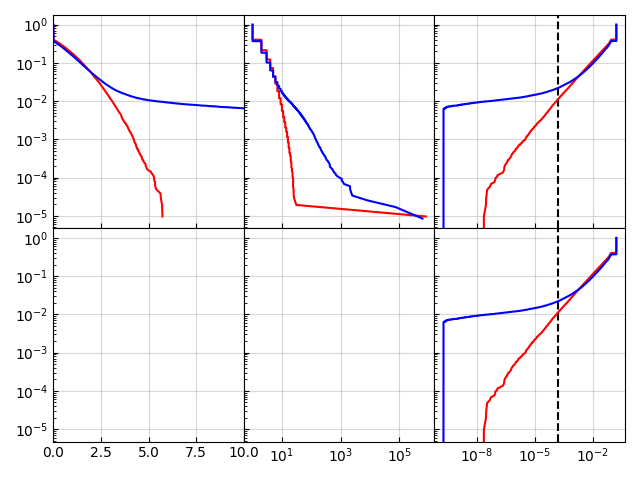

In [31]:
plt.close('SN_selection')
fig = plt.figure('SN_selection')
ax = fig.subplots(nrows=2, ncols=3, squeeze=False,
                  sharex='col', sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

#ax[0, 0].axvline(SN_threshold, c='k', ls='--')
ax[0, 0].plot(sorted_SN_inv, noise_above_SN, 'r-')
ax[0, 0].plot(sorted_SN, signal_above_SN, 'b-')
#ax[0, 0].set_xscale('log')
ax[0, 0].set_xlim(0, 10)
ax[0, 0].set_yscale('log')

#ax[0, 1].axvline(area_threshold, c='k', ls='--')
ax[0, 1].plot(sorted_area_inv, noise_above_area, 'r-')
ax[0, 1].plot(sorted_area, signal_above_area, 'b-')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

#ax[1, 0].axvline(SN_threshold, c='k', ls='--')
#ax[1, 0].plot(SN_mid, 2*hist_SN_inv/(hist_SN+hist_SN_inv), 'r-')
#ax[1, 0].set_yscale('log')

ax[0, 2].axvline(pnoise_threshold, c='k', ls='--')
ax[0, 2].plot(sorted_pnoise_inv, noise_below_pnoise, 'r-')
ax[0, 2].plot(sorted_pnoise, signal_below_pnoise, 'b-')
ax[0, 2].set_xscale('log')
ax[0, 2].set_yscale('log')

ax[1, 2].axvline(pnoise_threshold, c='k', ls='--')
ax[1, 2].plot(sorted_pnoise_inv, noise_below_pnoise, 'r-')
ax[1, 2].plot(sorted_pnoise, signal_below_pnoise, 'b-')
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')


In [32]:
#true_overdensity = max_value-min_value > np.interp(np.log(area), contrast_hull_x, contrast_hull_y, right=0)
true_overdensity = max_signal_to_noise > np.interp(np.log(area), signal_hull_x, signal_hull_y, right=0)
#true_overdensity = (max_signal_to_noise > SN_threshold)
#true_overdensity = (max_value-min_value > delta_th)
#true_overdensity &= (area > 3)
true_overdensity[0] = False
print(f'{np.count_nonzero(true_overdensity)} overdensities pass the selection criteria')

1204 overdensities pass the selection criteria


In [33]:
sorted_area_inv, noise_above_area

(array([     1,      1,      1, ...,     26,     31, 797159]),
 array([1.00000000e+00, 9.99990376e-01, 9.99980751e-01, ...,
        2.88728057e-05, 1.92485371e-05, 9.62426856e-06]))

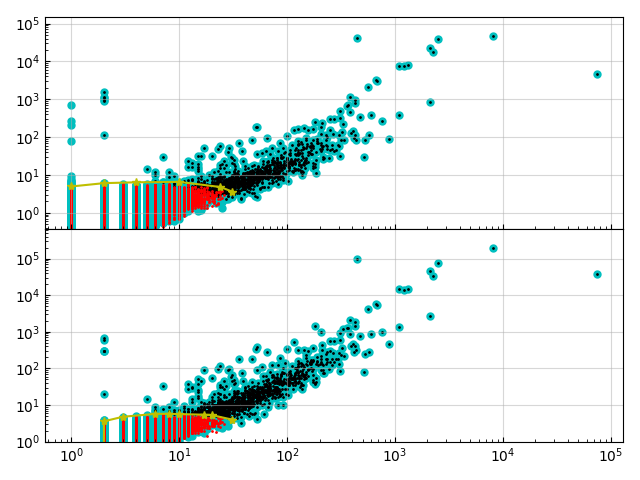

In [34]:
plt.close('catalogue_selection')
fig = plt.figure('catalogue_selection')
ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

#ax[0, 0].axhline(delta_th, c='k', ls=':')
ax[0, 0].scatter(area[1:], max_value[1:]-min_value[1:], s=25, c='c')
ax[0, 0].scatter(area[true_overdensity],
                 max_value[true_overdensity]-min_value[true_overdensity], s=1, c='k')
ax[0, 0].plot(np.exp(contrast_hull_x), contrast_hull_y, 'y-*')
ax[0, 0].scatter(area_inv[1:], max_value_inv[1:]-min_value_inv[1:], s=1, c='r')
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(np.min(contrast_hull_y[contrast_hull_y > 0])/10)

ax[1, 0].scatter(area[1:], max_signal_to_noise[1:], s=25, c='c')
ax[1, 0].scatter(area[true_overdensity], max_signal_to_noise[true_overdensity], s=1, c='k')
ax[1, 0].scatter(area_inv[1:], max_signal_to_noise_inv[1:], s=1, c='r')
ax[1, 0].plot(np.exp(signal_hull_x), signal_hull_y, 'y-*')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(1)

ax[-1, 0].set_xscale('log')


In [35]:
np.exp(signal_hull_x), signal_hull_y

(array([ 1.,  2.,  3.,  6.,  8., 10., 17., 20., 31.]),
 array([0.       , 3.5779095, 4.760144 , 5.7059097, 5.7243724, 5.6409917,
        5.41793  , 5.288861 , 3.9729393], dtype=float32))

## 4. Clean-up

### prune HOT based on selection threshold

In [36]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0
pruned_segmentation = segm.SegmentationImage(pruned_labels[label])

116835 yet to go
92796 yet to go
85465 yet to go
84371 yet to go
84282 yet to go
84278 yet to go


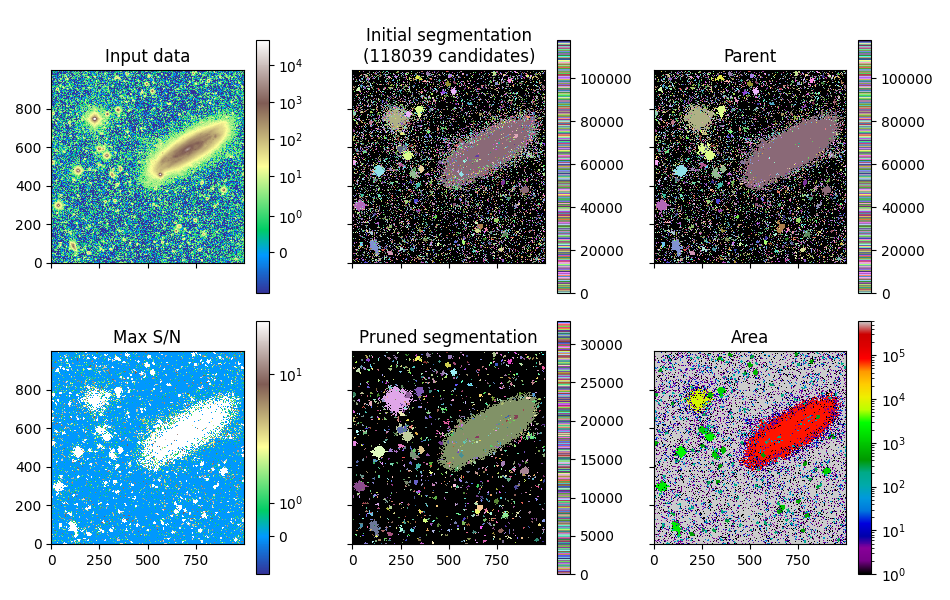

In [37]:
if data_dimensionality == 2:
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        (data-data_mode)/bg_std,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    ax[1, 0].set_title('Max S/N')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        max_signal_to_noise[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('Saddle value')
    im = ax[1, 1].imshow(
        saddle_value[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [38]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1205 objects after mode filtering


In [39]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [40]:
final_selection = segm.SegmentationImage(final_labels)

In [41]:
if data_dimensionality == 2:
    final_catalog = segm.SourceCatalog(data, final_selection)
    final_catalog.to_table()

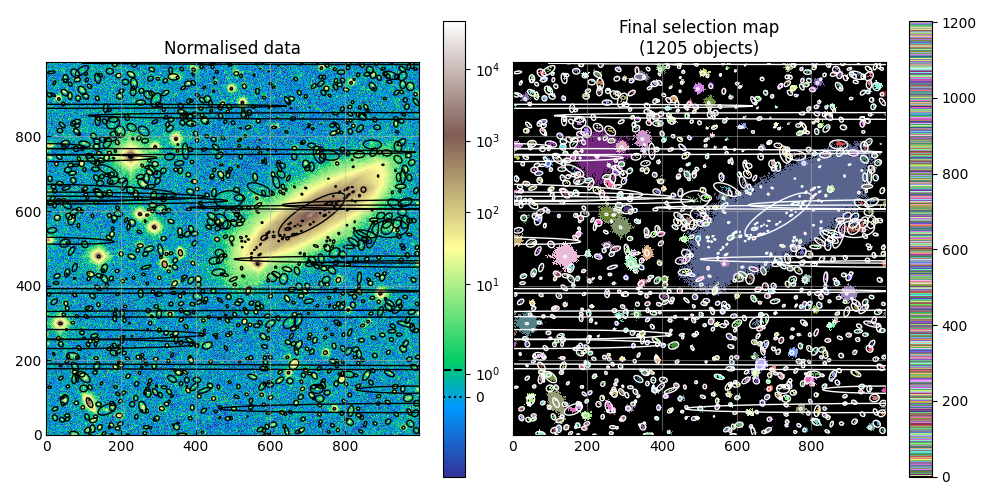

In [51]:
if data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Normalised data')
    im = ax[0, 0].imshow(
        (data-data_mode)/bg_std,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(delta_th, c='k', ls='--')
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')

    ax[0, 1].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


In [43]:
if data_dimensionality == 3:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data-data_mode, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.LogNorm(vmin=np.nanpercentile(data, 60))
    )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        norm = colors.SymLogNorm(vmin=np.nanpercentile(data, 60), linthresh=delta_th/10, vmax=np.nanpercentile(data, 99))
    )
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        np.nanmax(final_selection, axis=0),
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [44]:
if data_dimensionality == 3:
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        np.nansum(section_labels**2, axis=2).T / np.nansum(section_labels, axis=2).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = bg_std /np.sqrt(section.shape[1]*section.shape[2])
    factor = delta_th/bg_std
    ax[2, 0].axhline(factor*mean_error, c='k', ls=':')
    ax[2, 0].axhline(-factor*mean_error, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        np.nansum(section_labels**2, axis=1).T / np.nansum(section_labels, axis=1).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [45]:
'''
hdu = fits.PrimaryHDU(final_labels)
hdu.writeto('HOT_labels.fits', overwrite=True)
'''

'\n'

## Other tests

In [46]:
x = [10, 22, 20, 30, 10, 0, 1, 2]
xids = [1, 1, 0, 0, 2, 2, 2, 3]
s = np.zeros(4)
np.add.at(s, xids, x)
print(s)

[50. 32. 11.  2.]


In [47]:
old_label[16], parent[old_label[16]], new_parent[16], new_label[parent[old_label[16]]]

(18, 5, 5, 5)

In [52]:
x = np.random.normal(0, 1, (3, 2))

In [81]:
x, np.argsort(x.ravel())

(array([[ 0.40351466,  0.39041882],
        [-0.10289058,  0.43048022],
        [-0.4571925 , -1.36753713]]),
 array([5, 4, 2, 1, 0, 3]))

In [84]:
ind = np.dstack(np.unravel_index(np.argsort(x.ravel()), x.shape))[0]
for i in ind:
    print(f'> x[{i}] = {x[tuple(i)]} <')
    print(f'---')

> x[[2 1]] = -1.3675371304654511 <
---
> x[[2 0]] = -0.45719250295249825 <
---
> x[[1 0]] = -0.10289058393541661 <
---
> x[[0 1]] = 0.3904188200135978 <
---
> x[[0 0]] = 0.40351466488259 <
---
> x[[1 1]] = 0.4304802210324801 <
---


In [73]:
np.dstack(ind)[0]

array([[2, 2, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 1]])

In [82]:
ind.shape

(6, 2)